# Name: Ji WEI
# June 3rd, 2017
# 3. A one sentence description of your approach
# 4. The estimated AUC you would expect to get on the test.csv data
# 5. A one sentence description of a special skill you demonstrated

In [22]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

from sklearn import preprocessing, neighbors, model_selection
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('train.csv')
df

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0
...,...,...,...,...,...,...,...,...,...,...
9995,41,0.004225,desktop,M,0,64489,2,3,8,0
9996,50,0.004751,other,F,0,88643,1,3,0,0
9997,60,0.003804,other,M,0,87870,2,2,9,0
9998,18,0.003838,laptop,M,0,56468,2,2,0,0


In [3]:
print(df.shape)
print (sum([True for idx,row in df.iterrows() if any(row.isnull())]))
null_data = df[df.isnull().any(axis=1)]
null_data
#Dig into numeric variables, find the missing value.

(10000, 10)
269


,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
15,32,0.003519,Android,NaN,0,71909,1,3,8,0
38,54,0.005529,iPhone,NaN,0,87122,2,3,8,0
91,35,0.005510,iPhone,NaN,0,52343,1,3,3,0
113,41,0.004282,Android,NaN,0,72978,2,2,11,0
122,34,0.005518,iPhone,NaN,0,50425,2,3,3,0
...,...,...,...,...,...,...,...,...,...,...
9598,58,0.003698,Android,NaN,1,84495,2,1,17,0
9661,21,0.003397,laptop,NaN,1,34907,2,3,0,0
9745,55,0.003876,Android,NaN,1,69374,1,3,15,0
9886,41,0.004150,Android,NaN,1,46060,2,2,2,0


In [4]:
df1 = df.fillna(value = 'NA')# df1 contains cleaned date with gender column.
null_data1 = df1[df1.isnull().any(axis=1)]
null_data1 # Perfectly filled the missing value.

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome


In [5]:
color = df1.outcome.map({'1': 'red', '0': 'green'})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10df1f630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113db3048>]], dtype=object)

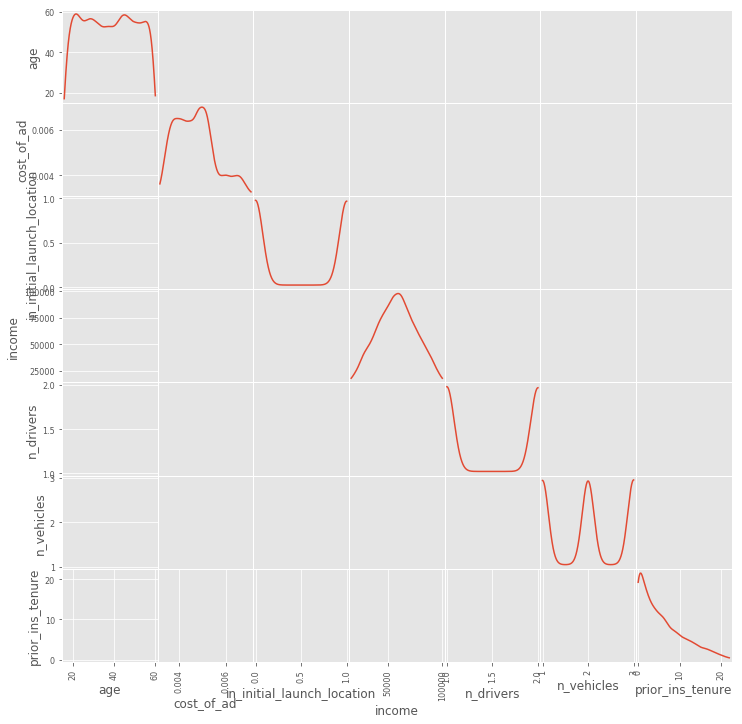

In [8]:
pd.plotting.scatter_matrix(
    df1[ ['age','cost_of_ad','device_type','gender','in_initial_launch_location','income',\
           'n_drivers','n_vehicles','prior_ins_tenure'] ],
    diagonal = 'kde', s = 75, c = color, figsize = (12, 12)
)

In [12]:
df1['device_n'] = pd.Categorical(df1.device_type).codes
df1['gender_n'] = pd.Categorical(df1.gender).codes
df1

,age,cost_of_ad,device_type,gender,in_initial_launch_location,...,prior_ins_tenure,outcome,device_n,gender_n,is_train
0,56,0.005737,iPhone,M,0,...,4,0,2,1,True
1,50,0.004733,desktop,F,0,...,2,0,1,0,True
2,54,0.004129,laptop,M,0,...,7,0,3,1,True
3,16,0.005117,Android,F,0,...,0,0,0,0,True
4,37,0.003635,desktop,M,0,...,5,0,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...
9995,41,0.004225,desktop,M,0,...,8,0,1,1,True
9996,50,0.004751,other,F,0,...,0,0,4,0,True
9997,60,0.003804,other,M,0,...,9,0,4,1,True
9998,18,0.003838,laptop,M,0,...,0,0,3,1,False


In [13]:
df1['is_train'] = np.random.uniform(0, 1, len(df1)) <= .75
train, tests = df1[df1['is_train']==True], df1[df1['is_train']==False]
print(train.shape)
print(tests.shape)

(7540, 13)
(2460, 13)


In [65]:
cols = ['age','cost_of_ad','device_n','gender_n','in_initial_launch_location','income',\
           'n_drivers','n_vehicles','prior_ins_tenure']
X = train[cols]

scaler = preprocessing.MinMaxScaler().fit(X)

X = scaler.transform(X)
colsRes = train['outcome']
y, _ = pd.factorize(colsRes)

In [85]:
w0=9.1 #weight associated to 0's
w1=1 #weight associated to 1's
knn = neighbors.KNeighborsClassifier(n_neighbors = 2, weights = 'distance',).fit(X, y)


In [86]:
test_X = tests[cols]
test_X = scaler.transform(test_X)
results = knn.predict(test_X)

In [87]:
(results == tests['outcome']).mean()

0.85162601626016265

In [88]:
pd.crosstab(results, tests['outcome'], rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,2008,183
1,182,87


In [89]:
roc_auc_score(tests['outcome'], results)

0.61955859969558602